In [3]:
import tensorflow as tf
import pickle

In [23]:
X = pickle.load(open('../Data/X_train_triplet', 'rb'))
test = pickle.load(open('../Data/X_test_triplet', 'rb'))
y = pickle.load(open('../Data/y_test', 'rb'))

In [113]:
class siamese:

    # Create model
    def __init__(self):
        tf.reset_default_graph()
        self.x1 = tf.placeholder(tf.float32, [None, 978])
        self.x2 = tf.placeholder(tf.float32, [None, 978])
        self.x3 = tf.placeholder(tf.float32, [None, 978])

        with tf.variable_scope("siamese") as scope:
            self.o1 = self.network(self.x1)
            scope.reuse_variables()
            self.o2 = self.network(self.x2)
            scope.reuse_variables()
            self.o3 = self.network(self.x3)

        self.loss = self.loss_with_step()

    def network(self, x):
        weights = []
        fc1 = self.fc_layer(x, 1024, "fc1")
        ac1 = tf.nn.relu(fc1)
        fc2 = self.fc_layer(ac1, 1024, "fc2")
        ac2 = tf.nn.relu(fc2)
        fc3 = self.fc_layer(ac2, 32, "fc3")
        fc3 = tf.nn.l2_normalize(fc3, axis=1)
        return fc3

    def fc_layer(self, bottom, n_weight, name):
        assert len(bottom.get_shape()) == 2
        n_prev_weight = bottom.get_shape()[1]
        initer = tf.truncated_normal_initializer(stddev=0.01)
        W = tf.get_variable(name+'W', dtype=tf.float32, shape=[n_prev_weight, n_weight], initializer=initer)
        b = tf.get_variable(name+'b', dtype=tf.float32, initializer=tf.constant(0.01, shape=[n_weight], dtype=tf.float32))
        fc = tf.nn.bias_add(tf.matmul(bottom, W), b)
        return fc

    def loss_with_step(self):  
        eucd2 = tf.pow(tf.subtract(self.o1, self.o2), 2)
        eucd2 = tf.sqrt(tf.reduce_sum(eucd2, axis=1))
        eucd2_mean = tf.reduce_mean(eucd2, axis=0)
        
        eucd3 = tf.pow(tf.subtract(self.o1, self.o3), 2)
        eucd3 = tf.sqrt(tf.reduce_sum(eucd3, axis=1))
        eucd3_mean = tf.reduce_mean(eucd3, axis=0)
        
        return eucd2_mean, eucd3_mean, eucd2, eucd3

In [114]:
s = siamese()
optim_pos = tf.train.AdamOptimizer(0.005).minimize(s.loss[0])
optim_neg = tf.train.AdamOptimizer(0.005).minimize(-s.loss[1])

In [ ]:
with tf.Session() as session:  
    tf.initialize_all_variables().run()
    print("Initialized")
    
    feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]}
    
    p_loss = []
    n_loss = []
    
    for a in range(50):        
        p_loss.append([])
        n_loss.append([])
        for b in range(len(X[0])):
            sys.stdout.write('\rEpoch %d:\t%d/%d' % (a, b, len(X[0])))
            feed_dict = {s.x1:X[0][b:b+1], s.x2:X[1][b:b+1], s.x3:X[2][b:b+1]}
            _, _, l = session.run([optim_pos, optim_neg, s.loss], feed_dict=feed_dict)
            p_loss[-1].append(l[0])
            n_loss[-1].append(l[1])
        p_loss[-1] = sum(p_loss[-1])/len(p_loss[-1])
        n_loss[-1] = sum(n_loss[-1])/len(n_loss[-1])
        print(" ", p_loss[-1], n_loss[-1]) 
    
    trained = session.run([s.loss], feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]})
    pred = session.run([s.loss], feed_dict={s.x1:test[0], s.x2:test[1], s.x3:test[2]})
    
    

Initialized
Epoch 0:	419/420  0.5341717644117862 0.8766641574867424
Epoch 1:	419/420  0.4644586531201466 0.9599724324863581
Epoch 2:	419/420  0.41970584496988783 1.0865199414614055
Epoch 3:	419/420  0.4067787584455107 1.2535062073574712
Epoch 4:	419/420  0.34836789435025173 1.3692935541538256
Epoch 5:	320/420

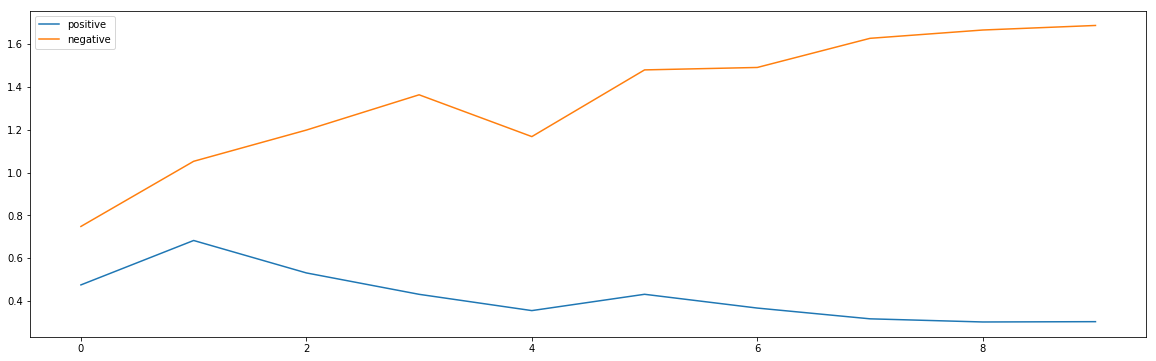

In [49]:
plt.figure(figsize=(20, 6))
plt.plot(np.arange(10), p_loss, label='positive')
plt.plot(np.arange(10), n_loss, label='negative')
plt.legend()
plt.show()

In [104]:
values = []
for i in pred:
    anch = normalize(i[0:16].reshape(1,-1)).flatten()
    pos = normalize(i[16:32].reshape(1,-1)).flatten()
    neg = normalize(i[32:].reshape(1,-1)).flatten()
    pos_neg_val = [(np.dot(anch,pos)), (np.dot(anch,neg))]
    print(pos_neg_val)
    values.append(pos_neg_val[0]>=0.7)
    values.append(pos_neg_val[1]<0.7)
    # print(positives, negatives)
    #     print(pos_val, neg_val, pos_val>neg_val)
print((np.sum(np.asarray(values)==True))/len(values))

here


In [125]:
p = np.sum(trained[0][2]<=1)
n = np.sum(trained[0][3]>1)
print((p+n)/420/2)

0.9154761904761904


In [126]:
p = np.sum(pred[0][2]<=1)
n = np.sum(pred[0][3]>1)
print((p+n)/420/2)

0.6285714285714286
